# Предсказание количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
# настроим отображение формата float
pd.set_option('display.float_format', '{:.2f}'.format)

# настроим отображение всех столбцов таблиц
pd.set_option('display.max_columns', None)

## Подготовка и анализ

### Загрузка данных

Загрузим даннные. В качестве индексов запишем столбец дат и времени - `datetime`, а также при импорте данных определим его тип как тип дат. 

In [3]:
try:
    data = pd.read_csv('/Users/anastasia/Documents/YandexPractikum/Спринт_12_Временные ряды/Проект_12/taxi.csv', 
                   parse_dates=[0], index_col=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отметим, что данные целочисленного формата `int`, а также, что в данных отсутствуют пропуски. 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Также проверим, что соблюдена хронология: 

In [5]:
print(data.index.is_monotonic)

True


### Подготовка данных

Ресемплируем выборку по одному часу и изучим ее:

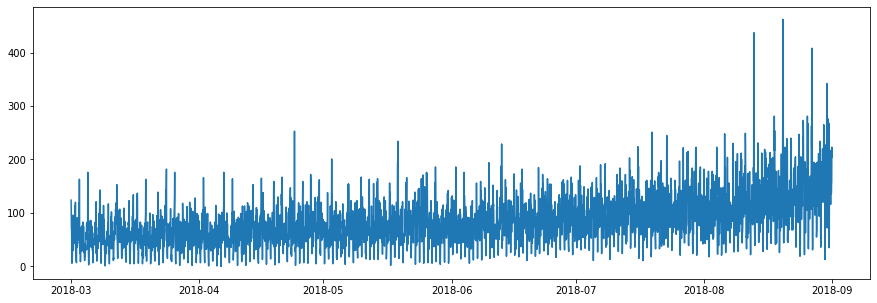

In [6]:
# ресемплируем
data = data.resample('1H').sum()
# визуализируем
plt.figure(figsize=(15,5))
plt.plot(data)

In [7]:
# посмотрим описательную статистику
data.describe()

,num_orders
count,4416.00
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


Можно отметить, что максимальное число заказов такси в аэропорт в час - 77, а среднее и медианное значение почти совпадают и составляют 13-14 вызовов. По характеристикам распределение напоминает нормальное. 


Проведем подготовку данных для возможности дальнейшего построения модели. Для начала посмотрим на стационарность данных и выделим такие компоненты ряда, как сезонность, тренд, шум:

In [8]:
# При p < 0.05 ряд можно считать стационарным
print(adfuller(data.loc[data['num_orders'].notnull(), 'num_orders'])[1])

0.02894005140261345


In [9]:
# разложим на тренд, сезонность и шум
decomposed = seasonal_decompose(data['num_orders'])

resid = decomposed.resid
trend = decomposed.trend
seasonal = decomposed.seasonal

Чтобы оценить тренд и сезонность визуально, возьмем более короткий срез данных: 

In [10]:
# добавим скользящее среднее за 24 часа 
ma = data['num_orders'].rolling(24).mean()

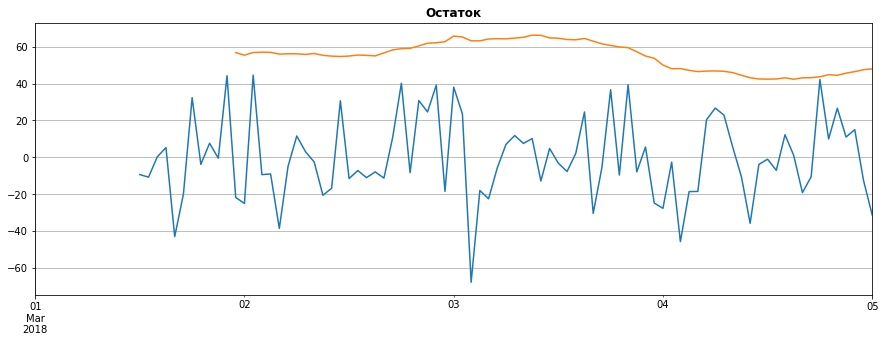

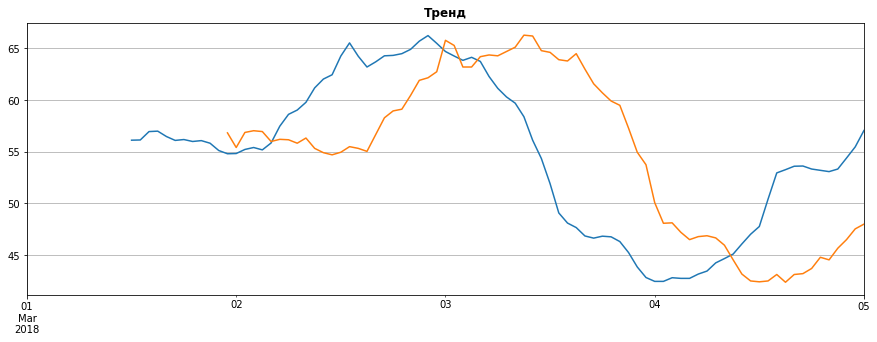

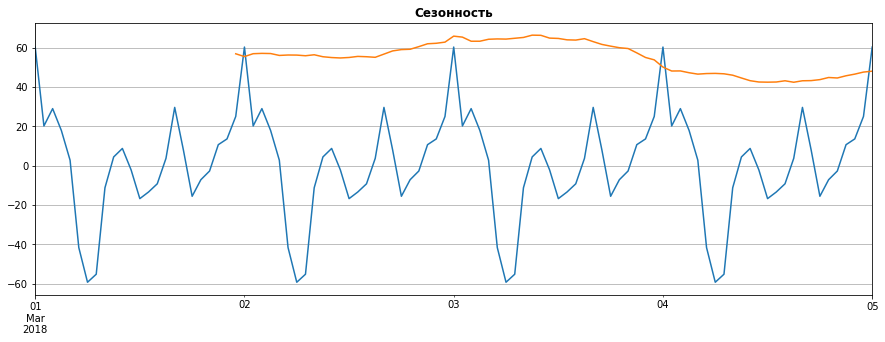

In [11]:
# Напишим функцию для построения графиков. 
# На вход функция будет принимать ряд (в данном случае - компонент после разложения на тренд, сезонность и шум),
# а также заголовок для каждого графика. На выходе функция возвращает три графика

def plot_decomposition(var1, name):
    plt.figure(figsize=(15,5))
    var1.plot(ax=plt.gca())
    ma['2018-03-01 00:00:00':'2018-03-05 00:00:00'].plot(ax=plt.gca())
    plt.title(name, weight="heavy")
    plt.xlabel('')
    plt.ylabel('')
    plt.grid()
    plt.show()
    
plot_decomposition(decomposed.resid['2018-03-01 00:00:00':'2018-03-05 00:00:00'], 'Остаток')
plot_decomposition(decomposed.trend['2018-03-01 00:00:00':'2018-03-05 00:00:00'], 'Тренд')
plot_decomposition(decomposed.seasonal['2018-03-01 00:00:00':'2018-03-05 00:00:00'], 'Сезонность')    

Можем отметить, что наименьшее число заказов, совершается в 6 часов утра, а наибольше в 12 часов ночи. Здесь можно говорить о внутрисуточной сезонности

Так как доступно данных меньше года, то сложно говорить о тренде, но предварительно можно предположить, что присутствует возрастающий тренд и проверить в дальнейшем. 

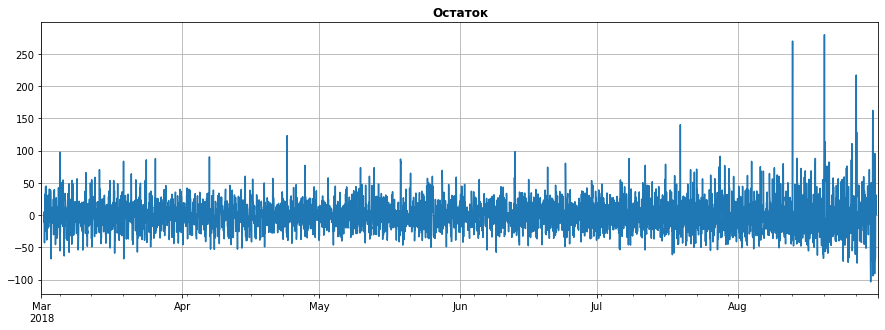

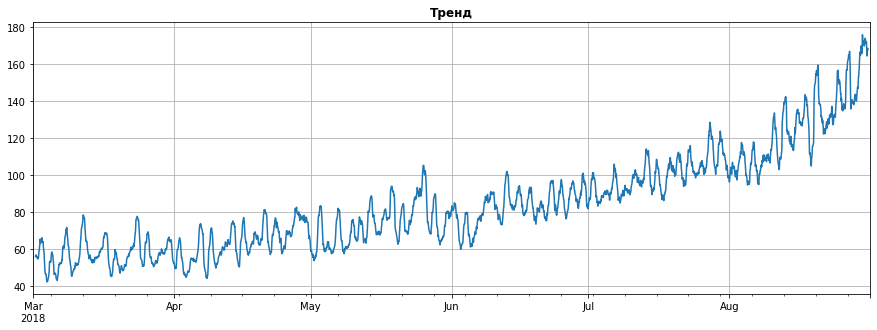

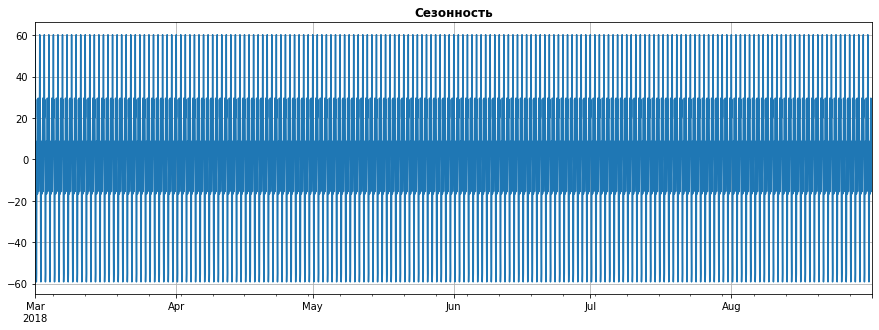

In [12]:
def plot_decomposition(var1, name):
    plt.figure(figsize=(15,5))
    var1.plot(ax=plt.gca())
    #ma['2018-03-01 00:00:00':'2018-08-05 00:00:00'].plot(ax=plt.gca())
    plt.title(name, weight="heavy")
    plt.xlabel('')
    plt.ylabel('')
    plt.grid()
    plt.show()
    
plot_decomposition(decomposed.resid, 'Остаток')
plot_decomposition(decomposed.trend, 'Тренд')
plot_decomposition(decomposed.seasonal, 'Сезонность')    

### Новые переменные 

Далее создадим переменные, которые могут помочь в объяснении и прогнозировании будущих значений о заказах такси. Среди этих данных будут актуальны дамми переменные для дня часа и недели, а также лаговые значения. 

Чтобы определить число необходимых лагов, которые могут помочь в прогнозировании переменной, посмотрим на автокорреляционную и частную автокорреляционную функции. Рассмотрим 10 лагов.

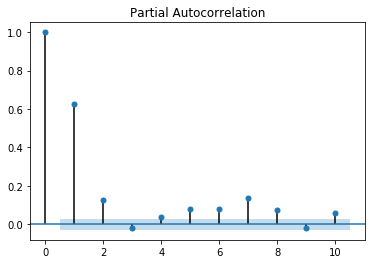

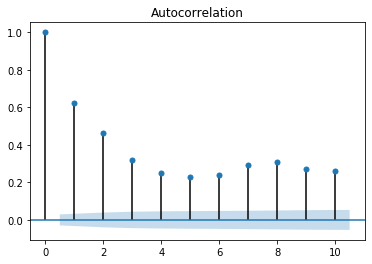

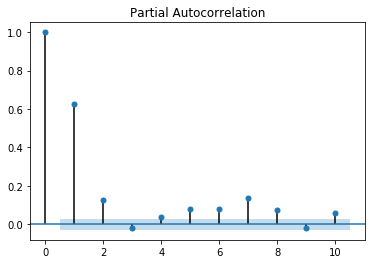

In [15]:
plot_acf(data['num_orders'], lags=10)
plot_pacf(data['num_orders'], lags=10)

In [16]:
def make_features(data, max_lag):
    data['hour'] = data.index.hour
    #data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [17]:
make_features(data, 3)
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,nan,nan,nan
2018-03-01 01:00:00,85,1,3,124.00,nan,nan
2018-03-01 02:00:00,71,2,3,85.00,124.00,nan
2018-03-01 03:00:00,66,3,3,71.00,85.00,124.00
2018-03-01 04:00:00,43,4,3,66.00,71.00,85.00


In [18]:
hour = pd.get_dummies(data['hour'], drop_first=True, prefix='hour')
day = pd.get_dummies(data['dayofweek'], drop_first=True, prefix='day')

data = data.join(hour)
data = data.join(day)

In [19]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-01 01:00:00,85,1,3,124.00,nan,nan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-01 02:00:00,71,2,3,85.00,124.00,nan,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-01 03:00:00,66,3,3,71.00,85.00,124.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-03-01 04:00:00,43,4,3,66.00,71.00,85.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [20]:
data.drop(['hour', 'dayofweek'], axis=1, inplace=True)

In [21]:
data = data[3:]

## Обучение и тестирование

Разделим выборку на тренироваочную и тестовую: 

In [22]:
target = data['num_orders']
features = data.drop('num_orders', axis=1)

target_train, target_test, features_train, features_test= train_test_split(
    target, features, shuffle=False, test_size=0.1)

In [23]:
print(target_train.shape)
print(features_train.shape)
print(target_train.index.min(), target_train.index.max())
print(features_train.index.min(), features_train.index.max())

(3971,)
(3971, 32)
2018-03-01 03:00:00 2018-08-13 13:00:00
2018-03-01 03:00:00 2018-08-13 13:00:00


In [24]:
print(target_test.shape)
print(features_test.shape)
print(target_test.index.min(), target_test.index.max())
print(features_test.index.min(), features_test.index.max())

(442,)
(442, 32)
2018-08-13 14:00:00 2018-08-31 23:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Создадим функцию для расчета метрики качества, по которой будем оценивать модель: 

In [25]:
def rmse(target, prediction):
    mse = mean_squared_error(target, prediction)
    rmse = (mse)**0.5
    return rmse 

rmse_score = make_scorer(rmse, greater_is_better=False)

Можем приступать к построению прогнозных моделей.

### Линейная регрессия

Для использования регресионных моделей нужно стандартизировать численные признаки:

In [26]:
stdsc = StandardScaler()

features_train_stdsc = stdsc.fit_transform(features_train)
features_test_stdsc = stdsc.transform(features_test)

In [27]:
reg = LinearRegression()
reg.fit(features_train_stdsc, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
prediction_reg = reg.predict(features_test_stdsc)
rmse_reg = rmse(target_test, prediction_reg)
print("Правильность на тестовом наборе: {:.2f}".format(rmse_reg))

Правильность на тестовом наборе: 47.30


### Дерево решений

In [29]:
param_grid_tree = {'max_depth': list(range(1, 16, 1))}

tscv = TimeSeriesSplit(n_splits=8)

grid_tree = GridSearchCV(
    DecisionTreeRegressor(), 
    param_grid_tree, cv=tscv, scoring=rmse_score)

grid_tree.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             pre_disp

In [30]:
prediction_tree = grid_tree.predict(features_test)
rmse_tree = rmse(target_test, prediction_tree)

print("Наилучшее значение правильности при перекрестной проверке:{:.2f}".format(grid_tree.best_score_))
print("Наилучшие параметры: {}".format(grid_tree.best_params_))
print("Правильность на тестовом наборе: {:.2f}".format(rmse_tree))

Наилучшее значение правильности при перекрестной проверке:-31.22
Наилучшие параметры: {'max_depth': 6}
Правильность на тестовом наборе: 60.69


### Случайный лес

In [31]:
param_grid_forest = {'max_depth':list(range(10, 16, 1)),'n_estimators':list(range(30, 101, 10))}

tscv = TimeSeriesSplit(n_splits=8)

grid_forest = GridSearchCV(
    RandomForestRegressor(), 
    param_grid_forest, cv=tscv, scoring=rmse_score)

grid_forest.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=No

In [32]:
prediction_forest = grid_forest.predict(features_test)
rmse_forest = rmse(target_test, prediction_forest)

print("Наилучшее значение правильности при перекрестной проверке:{:.2f}".format(grid_forest.best_score_))
print("Наилучшие параметры: {}".format(grid_forest.best_params_))
print("Правильность на тестовом наборе: {:.2f}".format(rmse_forest))

Наилучшее значение правильности при перекрестной проверке:-27.78
Наилучшие параметры: {'max_depth': 14, 'n_estimators': 40}
Правильность на тестовом наборе: 51.25


### Градиентный бустинг

In [33]:
param_grid_lgbm = {'depth':list(range(1, 20, 1)), 'learning_rate':[0.01, 0.1, 0.5],
                 'iterations':[500, 1000]}

tscv = TimeSeriesSplit(n_splits=8)

grid_lgbm = GridSearchCV(
    LGBMRegressor(loss_function='RMSE', verbose=500), param_grid_lgbm, cv=tscv, scoring=rmse_score)

grid_lgbm.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     loss_function='RMSE', max_depth=-1,
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0, verbose=500),
             iid='warn', n_jobs=None,
             param_grid={'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 

In [34]:
prediction_lgbm = grid_lgbm.predict(features_test)

rmse_lgbm = rmse(target_test, prediction_lgbm)

print("Наилучшее значение правильности при перекрестной проверке:{:.2f}".format(grid_lgbm.best_score_))
print("Наилучшие параметры: {}".format(grid_lgbm.best_params_))
print("Правильность на тестовом наборе: {:.2f}".format(rmse_lgbm))

Наилучшее значение правильности при перекрестной проверке:-28.64
Наилучшие параметры: {'depth': 1, 'iterations': 500, 'learning_rate': 0.1}
Правильность на тестовом наборе: 46.44


In [37]:
table = pd.DataFrame(data = [['LinearReg', rmse_reg], 
                             ['DecisionTree', rmse_tree], 
                             ['RandomForest', rmse_forest], 
                             ['LGBMR', rmse_lgbm]],
                     columns = ['MODEL','RMSE'])

table.sort_values(by='RMSE')

,MODEL,RMSE
3,LGBMR,46.44
0,LinearReg,47.30
2,RandomForest,51.25
1,DecisionTree,60.69


Наименьшая ошибка получается на основании прогноза модели линейной регрессии и модели градиентного бустинга. Визуализируем полученные значения:  

In [38]:
# приведем данные к формату series
test = pd.Series(target_test)
series_reg = pd.Series(prediction_reg, index=test.index)
series_lgbm = pd.Series(prediction_lgbm, index=test.index)

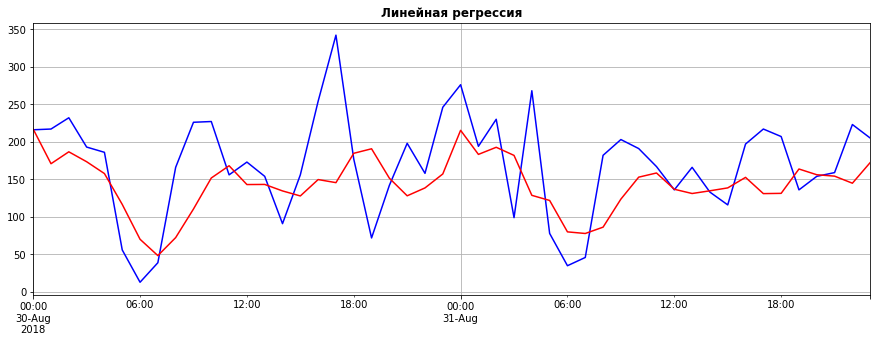

In [39]:
# график для прогноза линейной регрессии
plt.figure(figsize=(15,5))

test['2018-08-30 00:00:00':'2018-08-31 23:00:00'].plot(ax=plt.gca(), color='blue')
series_reg['2018-08-30 00:00:00':'2018-08-31 23:00:00'].plot(ax=plt.gca(), color='red')
plt.title('Линейная регрессия', weight="heavy")
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.show()

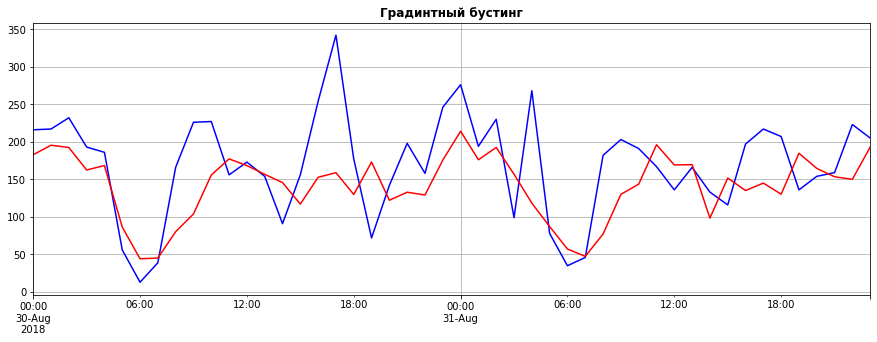

In [40]:
# график для прогноза градиентного бустинга
plt.figure(figsize=(15,5))
test['2018-08-30 00:00:00':'2018-08-31 23:00:00'].plot(ax=plt.gca(), color='blue')
series_lgbm['2018-08-30 00:00:00':'2018-08-31 23:00:00'].plot(ax=plt.gca(), color='red')
plt.title('Градинтный бустинг', weight="heavy")
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.show()

## Вывод

В ходе работы были проанализированы данные о заказах такси в аэропортах. В данных отмечается цикличность в рамках дня (пик заказов приходится на 12 часов ночи, а наименее активный час - 6 часов утра), а также был обнаружен небольшой восходящий тренд, который был нейтрализован путем взятия первой разности ряда. 

С целью построения модели для прогнозирования были обучены линейная регрессия, дерево решения, случайный лес и градиентный бустинг. Наименьшая ошибка RMSE при прогнозировании была получена в результате прогноза, полученного с помощью модели линейной регрессии, а также градиентного бустинга.  